In [428]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

np.set_printoptions(precision=3)
        
        
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.fuel_capacity = 100.0  # Maximum fuel capacity  
        self.fuel_consumption_rate = 0.01  # Fuel consumption rate per unit distance
        self.refill = 20
        self.combine = 40
        self.reset()    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
        self.fuel_level = self.fuel_capacity
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self, driving_style):
        if self.tyre == "Ultrasoft":
            vel = 80.7
        elif self.tyre == "Soft":
            vel = 80.1
        elif self.tyre == "Intermediate":
            vel = 79.5
        elif self.tyre == "Fullwet":
            vel = 79.0
            
         # Adjust velocity based on fuel level and driving style
        if driving_style == 1:
            velocity = vel * (0.9 * self.condition ** 1.5) * ((self.fuel_capacity / self.fuel_level))
        elif driving_style == 2:
            velocity = vel * (0.8 * self.condition ** 1.5) * ((self.fuel_capacity / self.fuel_level))
        elif driving_style == 3:
            velocity = vel * (0.7 * self.condition ** 1.5) * ((self.fuel_capacity / self.fuel_level))  
            
        return velocity
    

In [436]:
class Track:
    def __init__(self, car=Car(), driving_style=1):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.driving_style = driving_style 
        self.possible_driving_styles = [1, 2, 3]
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.crash_probability = 0.001
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.fill = False
        self.combine = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre,self.driving_style, self.car.fuel_level, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
    
    def calculate_crash_probability(self, velocity, driving_style):
        # Calculate crash probability based on velocity, wetness, and driving style
        crash_probability = 0.00001 * (velocity - 50) + 0.00005 * self.wetness[self.cur_weather] + self.laps_cleared * 0.000001
    
        # Adjust the crash probability based on driving style
        if driving_style == 2:
            crash_probability -= 0.00002  #djustment for a more aggressive driving style
        elif driving_style == 3:
            crash_probability += 0.00002  #adjustment for a more cautious driving style
    
        return crash_probability
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres withot fill
                1. Make a pitstop and fit new ‘Soft’ tyres withot fill
                2. Make a pitstop and fit new ‘Intermediate’ tyres withot fill
                3. Make a pitstop and fit new ‘Fullwet’ tyres withot fill
                4. Continue the next lap without changing tyres and withot fill
                5. Continue the next lap without changing tyres but fill
                6. Make a pitstop and fit new ‘Ultrasoft’ tyres and fill
                7. Make a pitstop and fit new ‘Soft’ tyres and fill
                8. Make a pitstop and fit new ‘Intermediate’ tyres and fill
                9. Make a pitstop and fit new ‘Fullwet’ tyres and fill
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            time_taken -= 2000
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
            if self.fill:
                self.car.fuel_level = self.car.fuel_capacity
                time_taken += self.car.refill
                self.fill = False
            if self.combine:
                self.car.change_tyre(self.committed_tyre)
                self.car.fuel_level = self.car.fuel_capacity
                time_taken += self.car.combine
                self.combine = False
                
                
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
#                 self.fill = False
#                 self.combine = False
                self.committed_tyre = self.car.possible_tyres[action]
            elif action == 4:
                self.pitstop = False
                self.fill = False
                self.combine = False
            elif action == 5:
#                 self.pitstop = False
                self.fill = True
#                 self.combine = False
            else:
#                 self.pitstop = False
#                 self.fill = False
                self.combine = True
                self.committed_tyre = self.car.possible_tyres[action-6]              
                
        # Calculate distance traveled and velocity
        velocity = self.car.get_velocity(self.driving_style)  # Use the predefined driving style
        distance = (2 * np.pi * self.radius / 8)
        
        
       # Check for crash event
        if np.random.random() < self.crash_probability:
            next_state = self._get_state()
            time_taken += 20000
            reward = 0 - time_taken
            self.is_done = True
#             print('crash')
#             next_state[5] = 'crash'
            return (reward, next_state , self.is_done, 0)  # Implement a massive negative reward for crashing
        
        # Add a check to avoid division by zero
        if velocity > 0:
            time_taken += distance / velocity
        else:
            time_taken += 10000  # You can choose a default time increment when velocity is zero or negative
            next_state = self._get_state()
            reward = 0 - time_taken
#             print('stop')
            self.is_done = True
#             next_state[5] = 'stop'
            return (reward, next_state , self.is_done, 0)

        # Calculate crash probability based on velocity and wetness
        if self.laps_cleared == int(self.laps_cleared):
            self.crash_probability = self.calculate_crash_probability(velocity, self.driving_style)
            
       
        # Apply degradation and fuel consumption
        self.car.degrade(w=self.wetness[self.cur_weather], r=self.radius)
        fuel_consumed = distance * self.car.fuel_consumption_rate 
        self.car.fuel_level -= fuel_consumed
        
        reward = 0 - time_taken
        self.laps_cleared += 0.125
        
        # Check if the race is finished
        if self.laps_cleared == self.total_laps:
            reward += 30000
            self.is_done = True

        if np.random.rand() < 0.05:
            self.driving_style = np.random.choice(self.possible_driving_styles)

        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity
        

In [437]:
class Agent:
    def __init__(self):
        pass
    
    def act(self, state):
        return 8

In [438]:
# Define the driving style
driving_style = 1  
# agent_risk_level = 0.1
new_car = Car()

env = Track(new_car,driving_style)

agent = Agent()

In [439]:
state = env.reset()    
done = False
G = 0
while not done:
    action = agent.act(state)
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward

print("G: %d" % G)

G: 121175


In [440]:
env.crash_probability

0.00019

In [441]:
state

['Intermediate', 2, 83.71084209113693, 0.964324, 'Dry', 1037, 74.25]

In [475]:
# Update QLearningAgent to include new actions
class QLearningAgent:
    def __init__(self, n_actions=10, alpha=0.1, gamma=0.99, epsilon=1, epsilon_decay=0.995):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = {}
        
    def _discretize_state(self, state):
#         print(state)
        tyre, driving_style, fuel,condition, cur_weather, radius, laps_cleared = state
        return (tyre, driving_style,fuel,round(condition, 2), cur_weather, radius, laps_cleared)
    
    def act(self, state):
        discrete_state = self._discretize_state(state)
        self.epsilon = self.epsilon * self.epsilon_decay 
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.n_actions)
        return np.argmax(self.get_q_values(discrete_state))

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.n_actions)
        return self.q_table[state]

    def update(self, state, action, reward, next_state):
        discrete_state = self._discretize_state(state)
        discrete_next_state = self._discretize_state(next_state)
        current_q = self.get_q_values(discrete_state)[action]
        next_max_q = np.max(self.get_q_values(discrete_next_state))
        updated_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * next_max_q)

        self.q_table[discrete_state][action] = updated_q

In [494]:
# Define the driving style
driving_style = 1  

# Create a new Car instance
new_car = Car()

# Create a Track instance with the specified driving style
env = Track(new_car, driving_style)
agent = QLearningAgent()

EPISODES = 10000

# Define different parameter sets
parameter_sets = [
    {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.94},
    {"alpha": 0.2, "gamma": 0.9, "epsilon": 0.1},
    {"alpha": 0.3, "gamma": 1, "epsilon": 0.5},
    {"alpha": 0.4, "gamma": 0.8, "epsilon": 0.8},
    {"alpha": 0.5, "gamma": 0.9, "epsilon": 0.98},
    {"alpha": 0.6, "gamma": 0.8, "epsilon": 0.7},
    {"alpha": 0.7, "gamma": 0.9, "epsilon": 0.9},
    {"alpha": 0.8, "gamma": 0.7, "epsilon": 1},
    {"alpha": 0.9, "gamma": 0.85, "epsilon": 1},
    {"alpha": 0.96, "gamma": 0.1, "epsilon": 1},
    {"alpha": 0.05, "gamma": 0, "epsilon": 0.9999},
    {"alpha": 0.03, "gamma": 0.2, "epsilon": 0.9},
    {"alpha": 0.02, "gamma": 0.7, "epsilon": 0.8},
    {"alpha": 1, "gamma": 0.999, "epsilon": 1}
]

α=1, γ=0.999, ε=1: 100%|██████████| 10000/10000 [00:17<00:00, 568.19it/s]


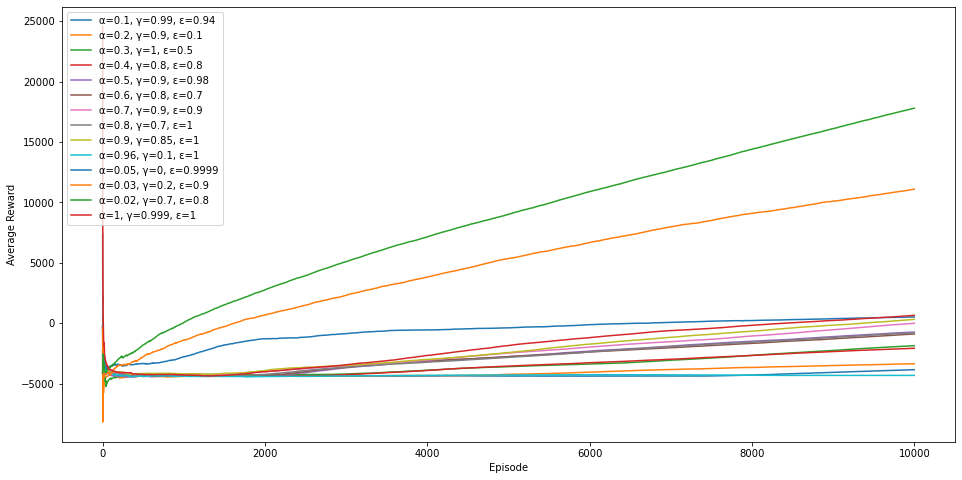

In [495]:
results = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])

    avg_rewards = []
    running_sum = 0

    for episode in tqdm(range(EPISODES), desc=f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'):
        state = env.reset()
        env.radius = 600
        done = False
        G = 0

        for step in range(EPISODES):  # Use a simple step counter
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            G += reward

            if done:
                break

        running_sum += G
        avg_reward = running_sum / (episode + 1)
        avg_rewards.append(avg_reward)

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
    results[param_label] = avg_rewards

# Plot results
plt.figure(figsize=(16, 8))
for param_label, avg_rewards in results.items():
    plt.plot(avg_rewards, label=param_label)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

### For our evn, most of the case, the agent would stop or encouter the car accident. Therefore, we set an augment rewards for agent if the agent can finish the game, we give huge reward to make the agent to finish the game first.


{"alpha": 0.02, "gamma": 0.7, "epsilon": 0.8}

In [516]:
# Define the driving style
driving_style = 1  

# Create a new Car instance
new_car = Car()

# Create a Track instance with the specified driving style
env = Track(new_car, driving_style)
agent = QLearningAgent()

EPISODES = 50000

# Define different parameter sets
parameter_sets = [
    {"alpha": 0.02, "gamma": 0.7, "epsilon": 0.8}
]

α=0.02, γ=0.7, ε=0.8: 100%|██████████| 50000/50000 [11:26<00:00, 72.79it/s] 


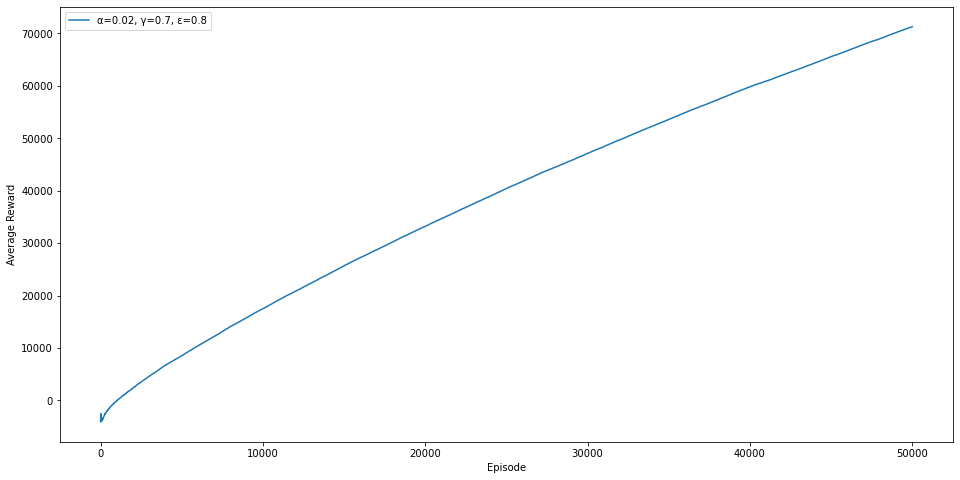

In [517]:
results = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])

    avg_rewards = []
    running_sum = 0

    for episode in tqdm(range(EPISODES), desc=f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'):
        state = env.reset()
        env.radius = 600
        done = False
        G = 0

        for step in range(EPISODES):  # Use a simple step counter
            action = agent.act(state)
            reward, next_state, done, velocity = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            G += reward

            if done:
                break

        running_sum += G
        avg_reward = running_sum / (episode + 1)
        avg_rewards.append(avg_reward)

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
    results[param_label] = avg_rewards

# Plot results
plt.figure(figsize=(16, 8))
for param_label, avg_rewards in results.items():
    plt.plot(avg_rewards, label=param_label)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

In [513]:
# Define the driving style
driving_style = 1  

# Create a new Car instance
new_car = Car()

# Create a Track instance with the specified driving style
env = Track(new_car, driving_style)
agent = QLearningAgent()

EPISODES = 4000

# Define different parameter sets
parameter_sets = [
    {"alpha": 0.02, "gamma": 0.7, "epsilon": 0.8}
]

100%|██████████| 4000/4000 [00:03<00:00, 1013.97it/s]


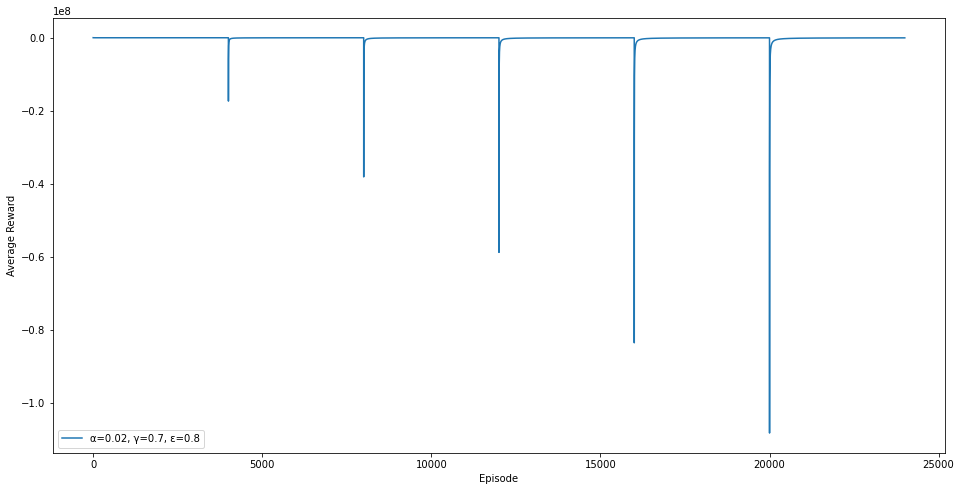

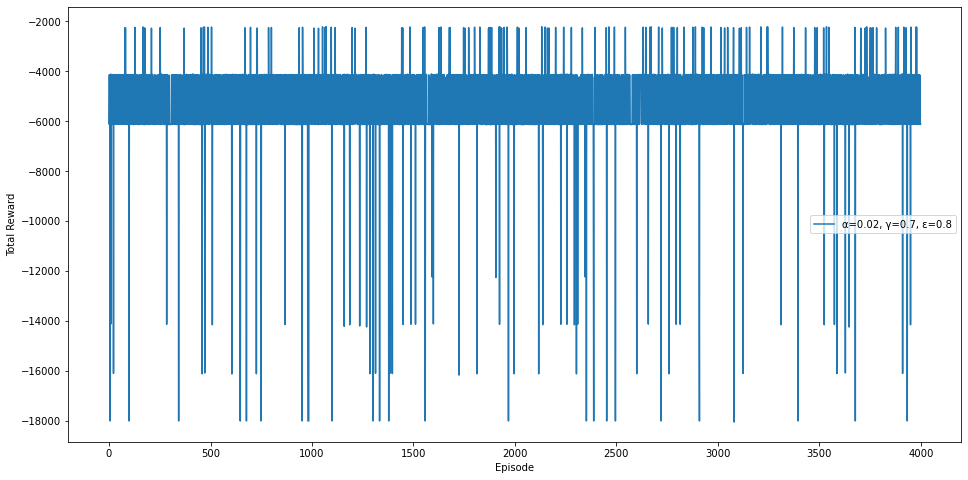

In [515]:
results = {}
all_rewards = {}

for params in parameter_sets:
    # Initialize agent with current parameters
    agent = QLearningAgent(alpha=params["alpha"], gamma=params["gamma"], epsilon=params["epsilon"])
    
    avg_rewards = []
    running_sum = 0

    # Train on different radius values
    radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]
    for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
        for episode in tqdm(range(EPISODES), desc=f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}, r=({start_radius}-{end_radius})'):
            state = env.reset()
            env.radius = np.random.randint(start_radius, end_radius)
            done = False
            G = 0
            for step in range(EPISODES):  # Use a simple step counter
                action = agent.act(state)
                reward, next_state, done, velocity = env.transition(action)
                agent.update(state, action, reward, next_state)
                state = next_state
                G += reward
                if done:
                    break
            running_sum += G
            avg_reward = running_sum / (episode + 1)
            avg_rewards.append(avg_reward)

    # Store average rewards for this parameter set
    param_label = f'α={params["alpha"]}, γ={params["gamma"]}, ε={params["epsilon"]}'
    results[param_label] = avg_rewards

    # Final training phase with random radii
    final_rewards = []
    for episode in tqdm(range(EPISODES)):
        state = env.reset()  # Reset with random radius
        done = False
        G = 0
        while not done:
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            agent.update(state, action, reward, next_state)
            state = deepcopy(next_state)
            G += reward
        final_rewards.append(G)

    all_rewards[param_label] = final_rewards

# Plot average rewards over episodes
plt.figure(figsize=(16, 8))
for param_label, avg_rewards in results.items():
    plt.plot(avg_rewards, label=param_label)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

# Plot total rewards for the last phase
plt.figure(figsize=(16, 8))
for param_label, final_rewards in all_rewards.items():
    plt.plot(final_rewards, label=param_label)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

### Baseline

Running Agent: 100%|██████████| 1000/1000 [00:08<00:00, 115.93it/s]


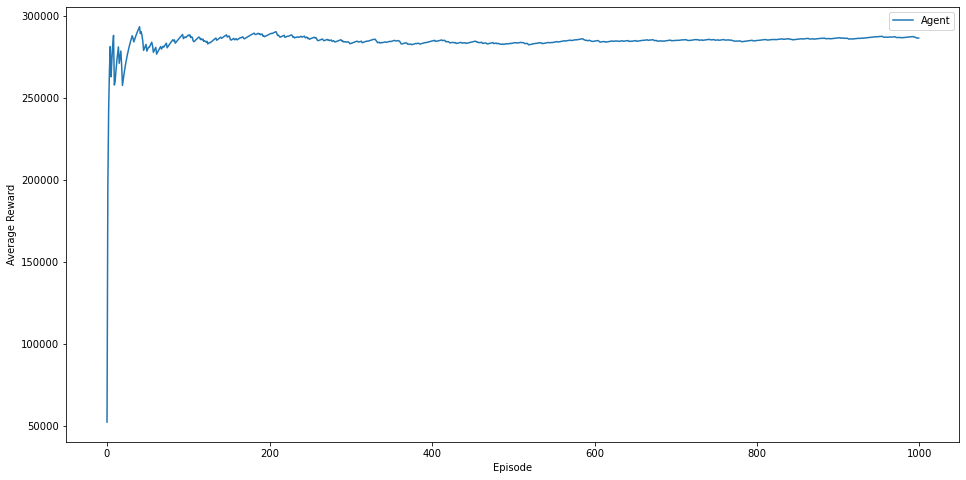

In [466]:
results = {}

# Initialize agent
agent = Agent()

avg_rewards = []
running_sum = 0

for episode in tqdm(range(1000), desc=f'Running Agent'):
    state = env.reset()
    env.radius = 600
    done = False
    G = 0

    for step in range(EPISODES):
        action = agent.act(state)
        reward, next_state, done, velocity = env.transition(action)
        state = next_state
        G += reward

        if done:
            break

    running_sum += G
    avg_reward = running_sum / (episode + 1)
    avg_rewards.append(avg_reward)

# Store average rewards
results['Agent'] = avg_rewards

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(avg_rewards, label='Agent')

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()